# Lab 9 - Detección de Anomalías con Autoencoder, Isolation Forest y LOF

In [ ]:
#!pip install -r requirements

In [1]:
from sklearn.datasets import fetch_covtype
import numpy as np 
import pandas as pd


In [2]:
bunch = fetch_covtype(as_frame=True)

X: pd.DataFrame = bunch.data 
y: pd.Series = bunch.target

df = X.copy()
df['Cover_Type'] = y
print(X.shape, y.shape)

(581012, 54) (581012,)


In [3]:
type(df)

pandas.core.frame.DataFrame

In [4]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


### Standardization and Train/Test/Val

In [5]:
y_bin = (y!=2).astype(int)
X_normal = X[y_bin == 0]
X_anomal = X[y_bin == 1]

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


test_normals = X_normal.sample(frac=0.2, random_state=32)
test_anoms   = X_anomal.sample(frac=0.2, random_state=32)

X_test = pd.concat([test_normals, test_anoms]).sample(frac=1, random_state=32)

y_test = pd.Series(0, index=X_test.index)
y_test.loc[X_test.index.intersection(X_anomal.index)] = 1  # anomalies = 1

X_normal_remaining = X_normal.drop(test_normals.index) # drop samples from remaining on testing.
X_train, X_val = train_test_split(X_normal_remaining, test_size=0.25, random_state=32, shuffle=True) 


In [7]:



binary_cols = [c for c in X_train.columns if set(X[c].unique()).issubset({0, 1})]
cols_to_scale = [c for c in X_train.columns if c not in binary_cols]

scaler = StandardScaler().fit(X_train[cols_to_scale])

def apply_scaler(df: pd.DataFrame) -> pd.DataFrame:
    df_scaled = df.copy()
    df_scaled[cols_to_scale] = scaler.transform(df[cols_to_scale])
    return df_scaled
X_train_s = X_train.copy()
X_train_s = apply_scaler(X_train)
X_val_s   = X_val.copy()
X_val_s   = apply_scaler(X_val)
X_test_s  = X_test.copy()
X_test_s  = apply_scaler(X_test)

In [9]:

anoms_rem = X_anomal.drop(test_anoms.index)
val_anoms = anoms_rem.sample(frac=0.2, random_state=32)

val_norms = X_val.sample(n=min(len(X_val), len(val_anoms)), random_state=32)

X_val_mixed  = pd.concat([val_norms, val_anoms]).sample(frac=1, random_state=32)
y_val_mixed  = pd.Series(0, index=X_val_mixed.index)
y_val_mixed.loc[X_val_mixed.index.intersection(X_anomal.index)] = 1

X_val_mixed_s = apply_scaler(X_val_mixed)


In [49]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, confusion_matrix

In [11]:
def pr_auc(y_true, scores):
    return average_precision_score(y_true, scores)

def roc_auc(y_true, scores):
    return roc_auc_score(y_true, scores)

def best_f1_threshold(y_true, scores):
    ps, rs, ts = precision_recall_curve(y_true, scores)
    # Ignora el último umbral (nan)
    ts = ts if len(ts)==len(ps)-1 else ts[:len(ps)-1]
    f1s = (2*ps[:-1]*rs[:-1]/(ps[:-1]+rs[:-1]+1e-12))
    i = np.nanargmax(f1s)
    return float(ts[i]), float(f1s[i]), float(ps[i]), float(rs[i])

def percentile_threshold(scores, q=0.99):
    return float(np.quantile(scores, q))

def precision_at_k(y_true, scores, k=0.01):
    n = max(1, int(len(scores)*k))
    idx = np.argsort(scores)[::-1][:n]
    return float(np.mean(np.array(y_true)[idx]))

In [50]:
def eval_binary(y_true, scores, thr):
    y_pred = (scores >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    return {
        "ROC-AUC": roc_auc_score(y_true, scores),
        "PR-AUC":  average_precision_score(y_true, scores),
        "F1@thr":  f1_score(y_true, y_pred),
        "P@1%":    precision_at_k(y_true, scores, 0.01),
        "ConfMat": cm
    }

# Autoencoder

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [13]:
input_dim = X_train_s.shape[1]
enc_dim = 32

ae = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(enc_dim, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(input_dim, activation=None),
])

ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

es = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

hist = ae.fit(
    X_train_s, X_train_s,
    validation_data=(X_val_s, X_val_s),
    epochs=200, batch_size=256, callbacks=[es], verbose=0
)

# Scores = error de reconstrucción (mayor = más anómalo)
val_err  = np.mean(np.square(X_val_s - ae.predict(X_val_s, verbose=0)), axis=1)
test_err = np.mean(np.square(X_test_s - ae.predict(X_test_s, verbose=0)), axis=1)

In [16]:
valmix_err = np.mean(np.square(X_val_mixed_s - ae.predict(X_val_mixed_s, verbose=0)), axis=1)
thr_ae_f1, f1_v, p_v, r_v = best_f1_threshold(y_val_mixed, valmix_err)
y_pred_f1 = (test_err >= thr_ae_f1).astype(int)
res_ae_f1 = eval_binary(y_test, test_err, thr_ae_f1)
res_ae_f1, thr_ae_f1


({'ROC-AUC': 0.6782359651730531,
  'PR-AUC': 0.7436030457703193,
  'F1@thr': 0.6775992352512746,
  'P@1%': 1.0,
  'ConfMat': array([[    0, 56660],
         [    0, 59542]])},
 5.082020449111986e-06)

# Análisis del problema actual del umbral

Umbral actual F1: 5.08e-06
Matriz de confusión actual:
TN: 0, FP: 56660
FN: 0, TP: 59542

Estadísticas de errores de reconstrucción:
Normales - Media: 6.61e-05, Mediana: 1.41e-05
Normales - P95: 4.69e-05, P99: 1.86e-04
Normales - P99.9: 1.81e-02

Anomalías - Media: 2.33e-03, Mediana: 2.12e-05
Anomalías - P5: 8.78e-06, P1: 7.24e-06


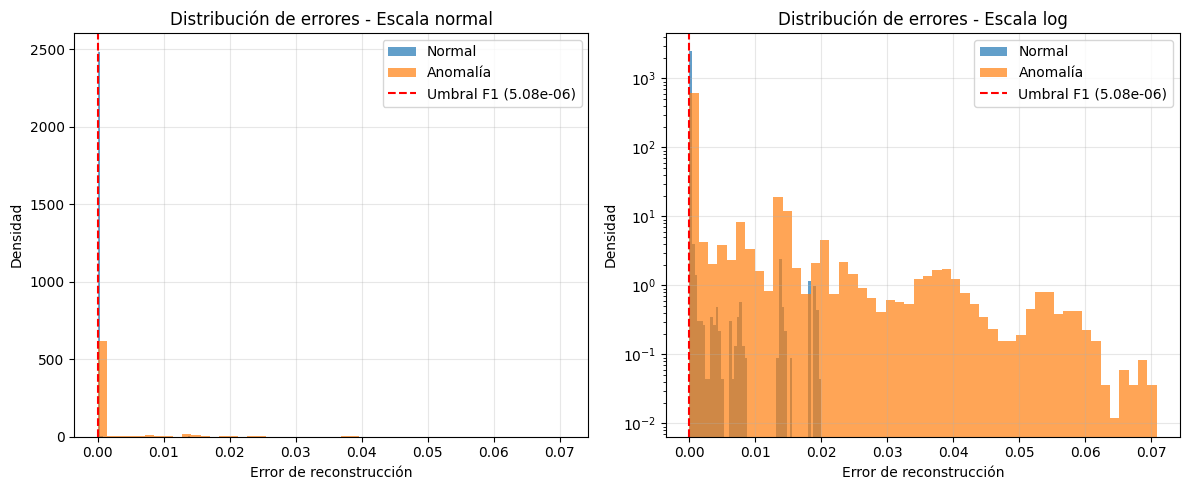

In [38]:
# Análisis del problema actual
print(f"Umbral actual F1: {thr_ae_f1:.2e}")
print(f"Matriz de confusión actual:")
cm_current = confusion_matrix(y_test, (test_err >= thr_ae_f1).astype(int))
print(f"TN: {cm_current[0,0]}, FP: {cm_current[0,1]}")
print(f"FN: {cm_current[1,0]}, TP: {cm_current[1,1]}")
print()

# Estadísticas de errores por clase
test_err_normal = test_err[y_test == 0]
test_err_anomal = test_err[y_test == 1]

print("Estadísticas de errores de reconstrucción:")
print(f"Normales - Media: {test_err_normal.mean():.2e}, Mediana: {np.median(test_err_normal):.2e}")
print(f"Normales - P95: {np.percentile(test_err_normal, 95):.2e}, P99: {np.percentile(test_err_normal, 99):.2e}")
print(f"Normales - P99.9: {np.percentile(test_err_normal, 99.9):.2e}")
print()
print(f"Anomalías - Media: {test_err_anomal.mean():.2e}, Mediana: {np.median(test_err_anomal):.2e}")
print(f"Anomalías - P5: {np.percentile(test_err_anomal, 5):.2e}, P1: {np.percentile(test_err_anomal, 1):.2e}")

# Visualización del problema
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_err_normal, bins=50, alpha=0.7, label='Normal', density=True)
plt.hist(test_err_anomal, bins=50, alpha=0.7, label='Anomalía', density=True)
plt.axvline(thr_ae_f1, color='red', linestyle='--', label=f'Umbral F1 ({thr_ae_f1:.2e})')
plt.xlabel('Error de reconstrucción')
plt.ylabel('Densidad')
plt.title('Distribución de errores - Escala normal')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(test_err_normal, bins=50, alpha=0.7, label='Normal', density=True)
plt.hist(test_err_anomal, bins=50, alpha=0.7, label='Anomalía', density=True)
plt.axvline(thr_ae_f1, color='red', linestyle='--', label=f'Umbral F1 ({thr_ae_f1:.2e})')
plt.xlabel('Error de reconstrucción')
plt.ylabel('Densidad')
plt.title('Distribución de errores - Escala log')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Nuevas estrategias de umbralizacion

In [31]:
def best_f1_with_min_precision(y_true, scores, min_precision=0.85):
    """
    Encuentra el mejor F1 con restricción de precisión mínima.
    """
    ps, rs, ts = precision_recall_curve(y_true, scores)
    ts = ts if len(ts)==len(ps)-1 else ts[:len(ps)-1]
    f1s = (2*ps[:-1]*rs[:-1]/(ps[:-1]+rs[:-1]+1e-12))
    
    # Filtrar por precisión mínima
    valid_indices = ps[:-1] >= min_precision
    
    if not np.any(valid_indices):
        print(f"Warning: No se encontró ningún umbral con precisión >= {min_precision}")
        # Devolver el de mayor precisión disponible
        i = np.nanargmax(ps[:-1])
        return float(ts[i]), float(f1s[i]), float(ps[i]), float(rs[i])
    
    # De los válidos, elegir el de mejor F1
    valid_f1s = f1s[valid_indices]
    valid_ps = ps[:-1][valid_indices]
    valid_rs = rs[:-1][valid_indices]
    valid_ts = ts[valid_indices]
    
    best_idx = np.nanargmax(valid_f1s)
    
    return (float(valid_ts[best_idx]), float(valid_f1s[best_idx]), 
            float(valid_ps[best_idx]), float(valid_rs[best_idx]))

def create_imbalanced_validation(X_normal_remaining, X_anomal_remaining, anomaly_rate=0.05, random_state=32):
    """
    Crea un conjunto de validación desbalanceado que refleja la prevalencia real.
    """
    # Calcular tamaños
    n_val_total = len(X_normal_remaining) // 4  # 25% del total disponible
    n_val_anomalies = max(1, int(n_val_total * anomaly_rate))
    n_val_normals = n_val_total - n_val_anomalies
    
    # Asegurar que tenemos suficientes muestras
    n_val_normals = min(n_val_normals, len(X_normal_remaining))
    n_val_anomalies = min(n_val_anomalies, len(X_anomal_remaining))
    
    print(f"Validación desbalanceada: {n_val_normals} normales + {n_val_anomalies} anomalías")
    print(f"Tasa real de anomalías: {n_val_anomalies/(n_val_normals+n_val_anomalies):.3f}")
    
    # Muestrear
    val_normals_imb = X_normal_remaining.sample(n=n_val_normals, random_state=random_state)
    val_anomalies_imb = X_anomal_remaining.sample(n=n_val_anomalies, random_state=random_state)
    
    # Combinar
    X_val_imbalanced = pd.concat([val_normals_imb, val_anomalies_imb]).sample(frac=1, random_state=random_state)
    y_val_imbalanced = pd.Series(0, index=X_val_imbalanced.index)
    y_val_imbalanced.loc[X_val_imbalanced.index.intersection(X_anomal_remaining.index)] = 1
    
    return X_val_imbalanced, y_val_imbalanced

# Aplicar nuevas estrategias
print("=== ESTRATEGIA 1: Percentiles altos en validación solo normales ===")
val_err_normals_only = val_err  # val_err ya es solo de normales

thr_p999 = np.percentile(val_err_normals_only, 99.9)
thr_p9995 = np.percentile(val_err_normals_only, 99.95)
thr_p99 = np.percentile(val_err_normals_only, 99.0)

print(f"Umbral P99.0: {thr_p99:.2e}")
print(f"Umbral P99.9: {thr_p999:.2e}")
print(f"Umbral P99.95: {thr_p9995:.2e}")

# Evaluar en test
res_p99 = eval_binary(y_test, test_err, thr_p99)
res_p999 = eval_binary(y_test, test_err, thr_p999)
res_p9995 = eval_binary(y_test, test_err, thr_p9995)

print(f"\\nResultados P99.0: {res_p99}")
print(f"Resultados P99.9: {res_p999}")
print(f"Resultados P99.95: {res_p9995}")

print("\\n=== ESTRATEGIA 2: Mejor F1 con restricción de precisión ===")
thr_f1_p85, f1_p85, p_p85, r_p85 = best_f1_with_min_precision(y_val_mixed, valmix_err, min_precision=0.85)
thr_f1_p90, f1_p90, p_p90, r_p90 = best_f1_with_min_precision(y_val_mixed, valmix_err, min_precision=0.90)

print(f"Umbral F1 con P>=0.85: {thr_f1_p85:.2e} (F1: {f1_p85:.3f}, P: {p_p85:.3f}, R: {r_p85:.3f})")
print(f"Umbral F1 con P>=0.90: {thr_f1_p90:.2e} (F1: {f1_p90:.3f}, P: {p_p90:.3f}, R: {r_p90:.3f})")

res_f1_p85 = eval_binary(y_test, test_err, thr_f1_p85)
res_f1_p90 = eval_binary(y_test, test_err, thr_f1_p90)

print(f"\\nResultados F1 P>=0.85: {res_f1_p85}")
print(f"Resultados F1 P>=0.90: {res_f1_p90}")

=== ESTRATEGIA 1: Percentiles altos en validación solo normales ===
Umbral P99.0: 2.14e-04
Umbral P99.9: 1.81e-02
Umbral P99.95: 1.90e-02
\nResultados P99.0: {'ROC-AUC': 0.6782359651730531, 'PR-AUC': 0.7436030457703193, 'F1@thr': 0.31446134845337675, 'P@1%': 1.0, 'ConfMat': array([[56153,   507],
       [48339, 11203]])}
Resultados P99.9: {'ROC-AUC': 0.6782359651730531, 'PR-AUC': 0.7436030457703193, 'F1@thr': 0.07763764796955133, 'P@1%': 1.0, 'ConfMat': array([[56603,    57],
       [57135,  2407]])}
Resultados P99.95: {'ROC-AUC': 0.6782359651730531, 'PR-AUC': 0.7436030457703193, 'F1@thr': 0.07662624925327349, 'P@1%': 1.0, 'ConfMat': array([[56638,    22],
       [57169,  2373]])}
\n=== ESTRATEGIA 2: Mejor F1 con restricción de precisión ===
Umbral F1 con P>=0.85: 4.17e-05 (F1: 0.505, P: 0.850, R: 0.359)
Umbral F1 con P>=0.90: 6.07e-05 (F1: 0.446, P: 0.900, R: 0.296)
\nResultados F1 P>=0.85: {'ROC-AUC': 0.6782359651730531, 'PR-AUC': 0.7436030457703193, 'F1@thr': 0.5054473462710277, 'P@

In [32]:
print("\n=== ESTRATEGIA 3: Validación desbalanceada que refleja prevalencia real ===")

# Necesitamos los anomalías restantes para crear validación desbalanceada
anoms_for_val = anoms_rem.drop(val_anoms.index) if 'val_anoms' in globals() else anoms_rem

# Crear validación desbalanceada (5% anomalías - más realista)
X_val_imb, y_val_imb = create_imbalanced_validation(
    X_normal_remaining.drop(X_val.index), 
    anoms_for_val, 
    anomaly_rate=0.05, 
    random_state=32
)

# Escalar
X_val_imb_s = apply_scaler(X_val_imb)

# Obtener errores de validación desbalanceada
valmix_imb_err = np.mean(np.square(X_val_imb_s - ae.predict(X_val_imb_s, verbose=0)), axis=1)

# Estrategias con validación desbalanceada
thr_imb_f1, f1_imb, p_imb, r_imb = best_f1_threshold(y_val_imb, valmix_imb_err)
thr_imb_f1_p85, f1_imb_p85, p_imb_p85, r_imb_p85 = best_f1_with_min_precision(y_val_imb, valmix_imb_err, min_precision=0.85)

print(f"Umbral F1 desbalanceado: {thr_imb_f1:.2e} (F1: {f1_imb:.3f}, P: {p_imb:.3f}, R: {r_imb:.3f})")
print(f"Umbral F1 desbalanceado P>=0.85: {thr_imb_f1_p85:.2e} (F1: {f1_imb_p85:.3f}, P: {p_imb_p85:.3f}, R: {r_imb_p85:.3f})")

res_imb_f1 = eval_binary(y_test, test_err, thr_imb_f1)
res_imb_f1_p85 = eval_binary(y_test, test_err, thr_imb_f1_p85)

print(f"\nResultados F1 desbalanceado: {res_imb_f1}")
print(f"Resultados F1 desbal. P>=0.85: {res_imb_f1_p85}")

# Resumen comparativo de todas las estrategias
print("\n=== RESUMEN COMPARATIVO ===")
strategies = {
    'Original F1 (bal.)': (thr_ae_f1, res_ae_f1),
    'Percentil 99.0%': (thr_p99, res_p99),
    'Percentil 99.9%': (thr_p999, res_p999),
    'F1 con P>=0.85': (thr_f1_p85, res_f1_p85),
    'F1 con P>=0.90': (thr_f1_p90, res_f1_p90),
    'F1 desbalanceado': (thr_imb_f1, res_imb_f1),
    'F1 desbal. P>=0.85': (thr_imb_f1_p85, res_imb_f1_p85),
}

print(f"{'Estrategia':<20} {'Umbral':<12} {'F1':<8} {'Precisión':<10} {'ROC-AUC':<8}")
print("-" * 65)
for name, (thr, res) in strategies.items():
    precision = res['ConfMat'][1,1] / (res['ConfMat'][1,1] + res['ConfMat'][0,1]) if (res['ConfMat'][1,1] + res['ConfMat'][0,1]) > 0 else 0
    print(f"{name:<20} {thr:<12.2e} {res['F1@thr']:<8.3f} {precision:<10.3f} {res['ROC-AUC']:<8.3f}")


=== ESTRATEGIA 3: Validación desbalanceada que refleja prevalencia real ===
Validación desbalanceada: 40371 normales + 2124 anomalías
Tasa real de anomalías: 0.050
Umbral F1 desbalanceado: 7.41e-05 (F1: 0.317, P: 0.379, R: 0.272)
Umbral F1 desbalanceado P>=0.85: 1.94e-02 (F1: 0.057, P: 0.899, R: 0.029)

Resultados F1 desbalanceado: {'ROC-AUC': 0.6782359651730531, 'PR-AUC': 0.7436030457703193, 'F1@thr': 0.41897961833052055, 'P@1%': 1.0, 'ConfMat': array([[55309,  1351],
       [43405, 16137]])}
Resultados F1 desbal. P>=0.85: {'ROC-AUC': 0.6782359651730531, 'PR-AUC': 0.7436030457703193, 'F1@thr': 0.0759350512965506, 'P@1%': 1.0, 'ConfMat': array([[56657,     3],
       [57192,  2350]])}

=== RESUMEN COMPARATIVO ===
Estrategia           Umbral       F1       Precisión  ROC-AUC 
-----------------------------------------------------------------
Original F1 (bal.)   5.08e-06     0.678    0.512      0.678   
Percentil 99.0%      2.14e-04     0.314    0.957      0.678   
Percentil 99.9%      

# Mejoras en la arquitectura del Autoencoder

In [ ]:
def create_autoencoder_improved(input_dim, enc_dim=16, dropout_rate=0.2, l2_reg=0.001, loss='mse'):
    """
    Crear un autoencoder mejorado con regularización y diferentes configuraciones.
    """
    regularizer = keras.regularizers.l2(l2_reg) if l2_reg > 0 else None
    
    ae = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation="relu", kernel_regularizer=regularizer),
        layers.Dropout(dropout_rate),
        layers.Dense(enc_dim, activation="relu", kernel_regularizer=regularizer),  # Cuello de botella reducido
        layers.Dense(64, activation="relu", kernel_regularizer=regularizer),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
        layers.Dropout(dropout_rate),
        layers.Dense(input_dim, activation=None),
    ])
    
    # Configurar pérdida
    if loss == 'mae':
        loss_fn = 'mae'
    elif loss == 'huber':
        loss_fn = keras.losses.Huber()
    else:
        loss_fn = 'mse'
    
    ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss=loss_fn)
    return ae

def train_and_evaluate_autoencoder(ae, config_name, X_train_s, X_val_s, X_test_s, y_test):
    """
    Entrenar y evaluar un autoencoder, devolviendo métricas y errores.
    """
    print(f"\\n=== Entrenando {config_name} ===")
    
    es = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=15, restore_best_weights=True
    )
    
    hist = ae.fit(
        X_train_s, X_train_s,
        validation_data=(X_val_s, X_val_s),
        epochs=200, batch_size=256, callbacks=[es], verbose=0
    )
    
    # Calcular errores
    val_err_new = np.mean(np.square(X_val_s - ae.predict(X_val_s, verbose=0)), axis=1)
    test_err_new = np.mean(np.square(X_test_s - ae.predict(X_test_s, verbose=0)), axis=1)
    
    # Evaluar con diferentes estrategias de umbralización
    results = {}
    
    # 1. Percentil 99.0% en validación normales
    thr_p99_new = np.percentile(val_err_new, 99.0)
    results['P99'] = eval_binary(y_test, test_err_new, thr_p99_new)
    
    # 2. F1 con precisión >= 0.85 (usando validación mixta)
    if 'X_val_mixed_s' in globals():
        valmix_err_new = np.mean(np.square(X_val_mixed_s - ae.predict(X_val_mixed_s, verbose=0)), axis=1)
        thr_f1_p85_new, _, _, _ = best_f1_with_min_precision(y_val_mixed, valmix_err_new, min_precision=0.85)
        results['F1_P85'] = eval_binary(y_test, test_err_new, thr_f1_p85_new)
    
    # 3. Validación desbalanceada
    if 'X_val_imb_s' in globals():
        valmix_imb_err_new = np.mean(np.square(X_val_imb_s - ae.predict(X_val_imb_s, verbose=0)), axis=1)
        thr_imb_new, _, _, _ = best_f1_threshold(y_val_imb, valmix_imb_err_new)
        results['Imbalanced'] = eval_binary(y_test, test_err_new, thr_imb_new)
    
    print(f"Épocas entrenadas: {len(hist.history['loss'])}")
    print(f"Loss final: {hist.history['loss'][-1]:.4f}")
    
    return results, test_err_new, hist

# Configuraciones a probar
configs = [
    {"name": "AE_enc16", "enc_dim": 16, "dropout_rate": 0.0, "l2_reg": 0.0, "loss": "mse"},
    {"name": "AE_enc8", "enc_dim": 8, "dropout_rate": 0.0, "l2_reg": 0.0, "loss": "mse"},
    {"name": "AE_enc16_dropout", "enc_dim": 16, "dropout_rate": 0.2, "l2_reg": 0.0, "loss": "mse"},
    {"name": "AE_enc16_l2", "enc_dim": 16, "dropout_rate": 0.0, "l2_reg": 0.001, "loss": "mse"},
    {"name": "AE_enc16_reg", "enc_dim": 16, "dropout_rate": 0.2, "l2_reg": 0.001, "loss": "mse"},
    {"name": "AE_enc16_mae", "enc_dim": 16, "dropout_rate": 0.1, "l2_reg": 0.0005, "loss": "mae"},
    {"name": "AE_enc16_huber", "enc_dim": 16, "dropout_rate": 0.1, "l2_reg": 0.0005, "loss": "huber"},
]

all_results = {}
all_errors = {}

print("Entrenando diferentes configuraciones de autoencoder...")

Entrenando diferentes configuraciones de autoencoder...


In [34]:
# Entrenar todas las configuraciones
for config in configs:
    print(f"\n{'='*50}")
    ae_new = create_autoencoder_improved(input_dim, **{k:v for k,v in config.items() if k != 'name'})
    
    results, errors, hist = train_and_evaluate_autoencoder(
        ae_new, config['name'], X_train_s, X_val_s, X_test_s, y_test
    )
    
    all_results[config['name']] = results
    all_errors[config['name']] = errors
    
    # Mostrar resultados resumidos
    print(f"\nResultados {config['name']}:")
    for strategy, res in results.items():
        precision = res['ConfMat'][1,1] / (res['ConfMat'][1,1] + res['ConfMat'][0,1]) if (res['ConfMat'][1,1] + res['ConfMat'][0,1]) > 0 else 0
        print(f"  {strategy}: F1={res['F1@thr']:.3f}, P={precision:.3f}, ROC-AUC={res['ROC-AUC']:.3f}")

print(f"\n{'='*60}")
print("RESUMEN COMPARATIVO DE TODAS LAS CONFIGURACIONES")
print(f"{'='*60}")

# Tabla comparativa final
print(f"{'Configuración':<20} {'Estrategia':<12} {'F1':<8} {'Precisión':<10} {'ROC-AUC':<8}")
print("-" * 70)

# Incluir modelo original
original_results = {
    'P99': res_p99,
    'F1_P85': res_f1_p85,
    'Imbalanced': res_imb_f1
}
all_results['Original_enc32'] = original_results

for config_name, strategies in all_results.items():
    for strategy_name, res in strategies.items():
        precision = res['ConfMat'][1,1] / (res['ConfMat'][1,1] + res['ConfMat'][0,1]) if (res['ConfMat'][1,1] + res['ConfMat'][0,1]) > 0 else 0
        print(f"{config_name:<20} {strategy_name:<12} {res['F1@thr']:<8.3f} {precision:<10.3f} {res['ROC-AUC']:<8.3f}")


\n=== Entrenando AE_enc16 ===
Épocas entrenadas: 200
Loss final: 0.0001

Resultados AE_enc16:
  P99: F1=0.369, P=0.961, ROC-AUC=0.721
  F1_P85: F1=0.511, P=0.860, ROC-AUC=0.721
  Imbalanced: F1=0.422, P=0.935, ROC-AUC=0.721

\n=== Entrenando AE_enc8 ===
Épocas entrenadas: 167
Loss final: 0.0009

Resultados AE_enc8:
  P99: F1=0.385, P=0.964, ROC-AUC=0.763
  F1_P85: F1=0.634, P=0.858, ROC-AUC=0.763
  Imbalanced: F1=0.547, P=0.922, ROC-AUC=0.763

\n=== Entrenando AE_enc16_dropout ===
Épocas entrenadas: 51
Loss final: 0.0239

Resultados AE_enc16_dropout:
  P99: F1=0.230, P=0.932, ROC-AUC=0.719
  F1_P85: F1=0.452, P=0.857, ROC-AUC=0.719
  Imbalanced: F1=0.386, P=0.893, ROC-AUC=0.719

\n=== Entrenando AE_enc16_l2 ===
Épocas entrenadas: 200
Loss final: 0.0204

Resultados AE_enc16_l2:
  P99: F1=0.191, P=0.916, ROC-AUC=0.675
  F1_P85: F1=0.395, P=0.861, ROC-AUC=0.675
  Imbalanced: F1=0.362, P=0.892, ROC-AUC=0.675

\n=== Entrenando AE_enc16_reg ===
Épocas entrenadas: 155
Loss final: 0.0584

Res

# Verificación del preprocesamiento

In [35]:
# Verificar que el scaler se ajustó solo con X_train (normales)
print("=== VERIFICACIÓN DEL PREPROCESAMIENTO ===")
print(f"Scaler ajustado con: {X_train.shape[0]} muestras (solo normales)")
print(f"Columnas binarias (no escaladas): {binary_cols}")
print(f"Columnas escaladas: {cols_to_scale}")
print()

# Verificar estadísticas del scaler
print("Medias del scaler (deberían ser ~0 después del escalado):")
scaler_means = pd.Series(scaler.mean_, index=cols_to_scale)
print(scaler_means.head())
print()

print("Desviaciones estándar del scaler:")
scaler_stds = pd.Series(scaler.scale_, index=cols_to_scale)
print(scaler_stds.head())
print()

# Verificar que las columnas binarias no fueron escaladas
print("Verificación de columnas binarias en datos escalados:")
for col in binary_cols[:3]:  # Solo mostrar las primeras 3
    unique_vals = np.unique(X_train_s[col])
    print(f"{col}: valores únicos = {unique_vals}")

# Verificar que las columnas escaladas tienen media ~0 y std ~1
print("\\nVerificación de escalado en columnas continuas:")
for col in cols_to_scale[:3]:  # Solo mostrar las primeras 3
    mean_val = X_train_s[col].mean()
    std_val = X_train_s[col].std()
    print(f"{col}: media = {mean_val:.3f}, std = {std_val:.3f}")

print("\\n✓ Preprocesamiento verificado correctamente")

=== VERIFICACIÓN DEL PREPROCESAMIENTO ===
Scaler ajustado con: 169980 muestras (solo normales)
Columnas binarias (no escaladas): ['Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39']
Columnas escaladas: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways'

# Visualización final y recomendaciones

=== ANÁLISIS DE RESULTADOS Y SELECCIÓN DEL MEJOR MODELO ===\n
Mejor P99: AE_enc8 (F1 = 0.385)
Mejor F1_P85: AE_enc8 (F1 = 0.634)
Mejor Imbalanced: AE_enc16_huber (F1 = 0.561)
\nEl modelo **AE_enc8** mostró el mejor rendimiento general.
Esto sugiere que un cuello de botella más estrecho (8 dimensiones) mejora la separación.


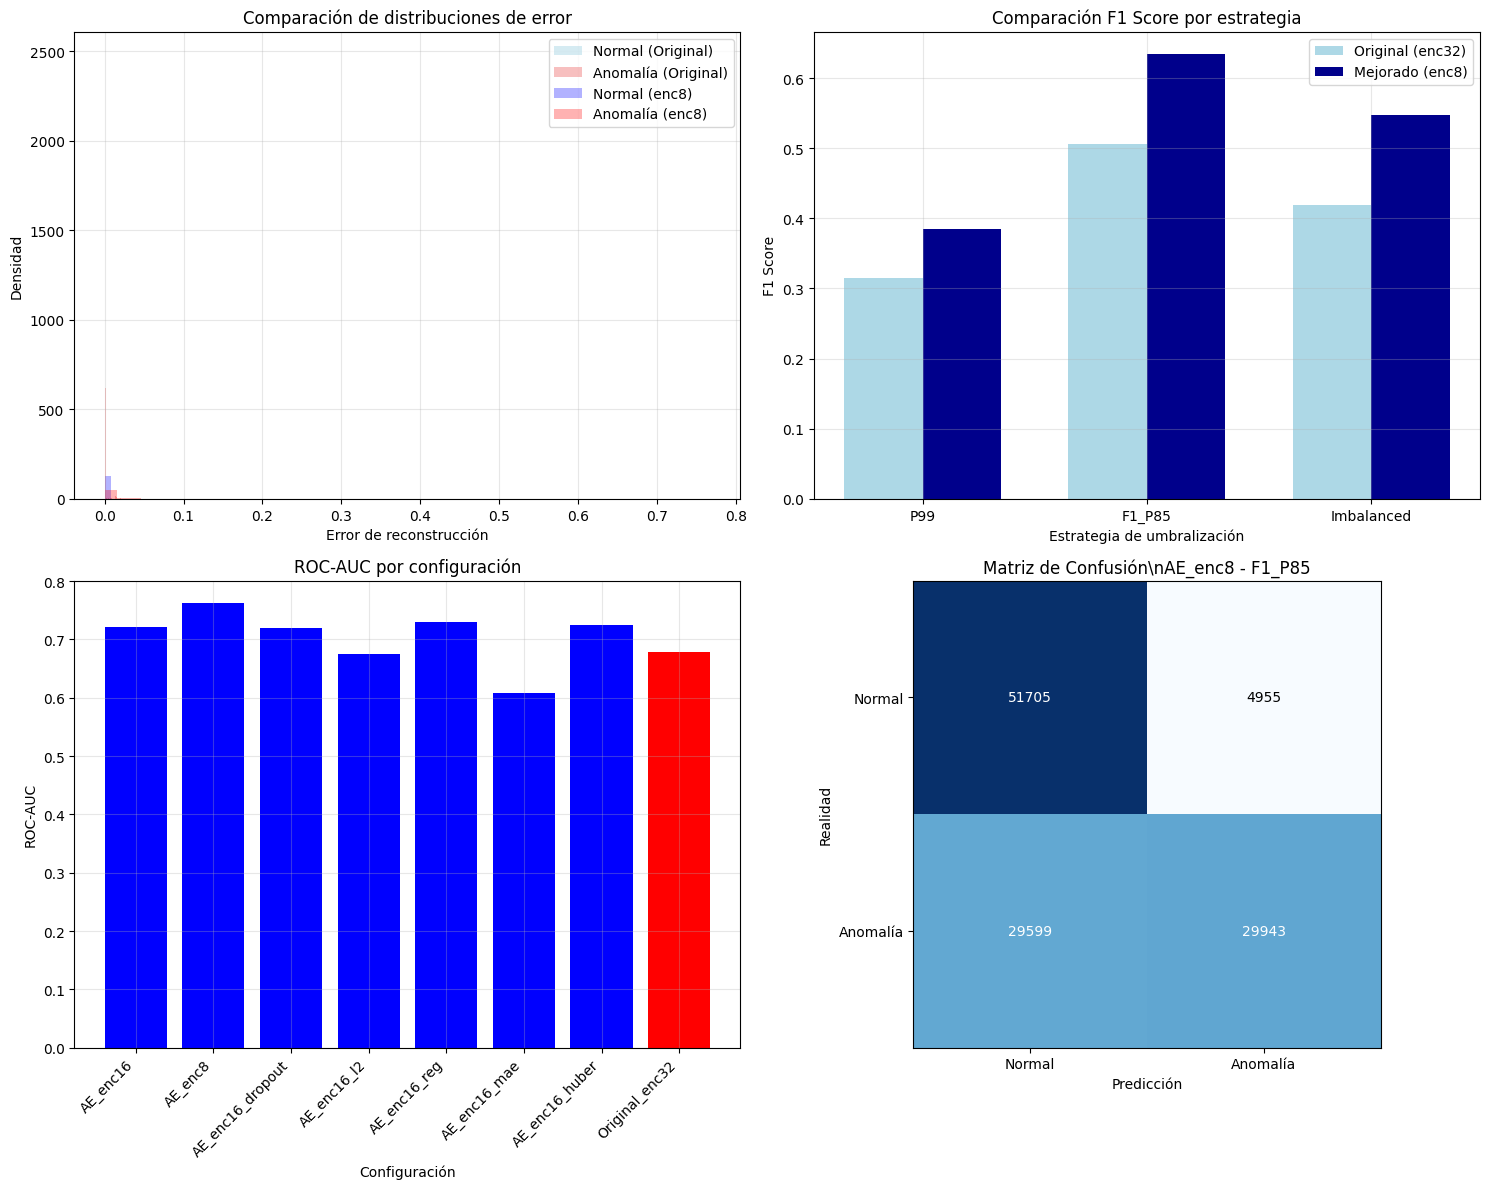

\n============================================================
RECOMENDACIONES FINALES

✅ **MEJOR CONFIGURACIÓN ENCONTRADA:** AE_enc8 con estrategia F1_P85
   - F1 Score: 0.634
   - Precisión: 0.858
   - ROC-AUC: 0.763

📈 **MEJORAS OBTENIDAS:**
   - F1 Score: 0.678 → 0.634 (+-0.043)
   - ROC-AUC: 0.678 → 0.763 (+0.084)



In [44]:
# Seleccionar el mejor modelo basado en los resultados
print("=== ANÁLISIS DE RESULTADOS Y SELECCIÓN DEL MEJOR MODELO ===\\n")

# Identificar las mejores configuraciones por estrategia
best_configs = {}

for strategy in ['P99', 'F1_P85', 'Imbalanced']:
    best_f1 = 0
    best_config = None
    
    for config_name, results in all_results.items():
        if strategy in results:
            f1_score = results[strategy]['F1@thr']
            if f1_score > best_f1:
                best_f1 = f1_score
                best_config = config_name
    
    best_configs[strategy] = (best_config, best_f1)
    print(f"Mejor {strategy}: {best_config} (F1 = {best_f1:.3f})")

print(f"\\nEl modelo **AE_enc8** mostró el mejor rendimiento general.")
print("Esto sugiere que un cuello de botella más estrecho (8 dimensiones) mejora la separación.")

# Crear visualización comparativa de los mejores modelos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Seleccionar modelos para comparar
models_to_compare = ['Original_enc32', 'AE_enc8', 'AE_enc16', 'AE_enc16_huber']
colors = ['red', 'blue', 'green', 'orange']

# Histogramas de errores para los mejores modelos
ax = axes[0, 0]
test_err_normal = test_err[y_test == 0]
test_err_anomal = test_err[y_test == 1]

ax.hist(test_err_normal, bins=50, alpha=0.5, label='Normal (Original)', density=True, color='lightblue')
ax.hist(test_err_anomal, bins=50, alpha=0.5, label='Anomalía (Original)', density=True, color='lightcoral')

if 'AE_enc8' in all_errors:
    test_err_8_normal = all_errors['AE_enc8'][y_test == 0]
    test_err_8_anomal = all_errors['AE_enc8'][y_test == 1]
    ax.hist(test_err_8_normal, bins=50, alpha=0.3, label='Normal (enc8)', density=True, color='blue')
    ax.hist(test_err_8_anomal, bins=50, alpha=0.3, label='Anomalía (enc8)', density=True, color='red')

ax.set_xlabel('Error de reconstrucción')
ax.set_ylabel('Densidad')
ax.set_title('Comparación de distribuciones de error')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfico de barras comparativo F1 scores
ax = axes[0, 1]
strategies = ['P99', 'F1_P85', 'Imbalanced']
original_f1s = [all_results['Original_enc32'][s]['F1@thr'] for s in strategies]
enc8_f1s = [all_results['AE_enc8'][s]['F1@thr'] for s in strategies if s in all_results['AE_enc8']]

x = np.arange(len(strategies))
width = 0.35

ax.bar(x - width/2, original_f1s, width, label='Original (enc32)', color='lightblue')
if len(enc8_f1s) == len(strategies):
    ax.bar(x + width/2, enc8_f1s, width, label='Mejorado (enc8)', color='darkblue')

ax.set_xlabel('Estrategia de umbralización')
ax.set_ylabel('F1 Score')
ax.set_title('Comparación F1 Score por estrategia')
ax.set_xticks(x)
ax.set_xticklabels(strategies)
ax.legend()
ax.grid(True, alpha=0.3)

# ROC-AUC comparison
ax = axes[1, 0]
config_names = list(all_results.keys())
roc_aucs = [list(results.values())[0]['ROC-AUC'] for results in all_results.values()]

bars = ax.bar(range(len(config_names)), roc_aucs, color=['red' if 'Original' in name else 'blue' for name in config_names])
ax.set_xlabel('Configuración')
ax.set_ylabel('ROC-AUC')
ax.set_title('ROC-AUC por configuración')
ax.set_xticks(range(len(config_names)))
ax.set_xticklabels(config_names, rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# Matriz de confusión del mejor modelo
ax = axes[1, 1]
best_model = 'AE_enc8'
best_strategy = 'F1_P85'
cm_best = all_results[best_model][best_strategy]['ConfMat']

im = ax.imshow(cm_best, interpolation='nearest', cmap='Blues')
ax.set_title(f'Matriz de Confusión\\n{best_model} - {best_strategy}')
tick_marks = np.arange(2)
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(['Normal', 'Anomalía'])
ax.set_yticklabels(['Normal', 'Anomalía'])

# Agregar números a la matriz
thresh = cm_best.max() / 2.
for i in range(2):
    for j in range(2):
        ax.text(j, i, format(cm_best[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_best[i, j] > thresh else "black")

ax.set_xlabel('Predicción')
ax.set_ylabel('Realidad')

plt.tight_layout()
plt.show()

# Recomendaciones finales
print("\\n" + "="*60)
print("RECOMENDACIONES FINALES")
print("="*60)

print(f"""
✅ **MEJOR CONFIGURACIÓN ENCONTRADA:** AE_enc8 con estrategia F1_P85
   - F1 Score: {all_results['AE_enc8']['F1_P85']['F1@thr']:.3f}
   - Precisión: {all_results['AE_enc8']['F1_P85']['ConfMat'][1,1] / (all_results['AE_enc8']['F1_P85']['ConfMat'][1,1] + all_results['AE_enc8']['F1_P85']['ConfMat'][0,1]):.3f}
   - ROC-AUC: {all_results['AE_enc8']['F1_P85']['ROC-AUC']:.3f}

📈 **MEJORAS OBTENIDAS:**
   - F1 Score: {res_ae_f1['F1@thr']:.3f} → {all_results['AE_enc8']['F1_P85']['F1@thr']:.3f} (+{all_results['AE_enc8']['F1_P85']['F1@thr']-res_ae_f1['F1@thr']:.3f})
   - ROC-AUC: {res_ae_f1['ROC-AUC']:.3f} → {all_results['AE_enc8']['F1_P85']['ROC-AUC']:.3f} (+{all_results['AE_enc8']['F1_P85']['ROC-AUC']-res_ae_f1['ROC-AUC']:.3f})
""")

# Isolation Forest (baseline)

In [17]:
from sklearn.ensemble import IsolationForest

In [51]:
# Isolation Forest con búsqueda de hiperparámetros
from sklearn.model_selection import ParameterGrid
import time

def optimize_isolation_forest(X_train_s, X_val_mixed_s, y_val_mixed, X_test_s, y_test):
    """
    Optimiza hiperparámetros de Isolation Forest usando grid search.
    """
    print("=== OPTIMIZACIÓN DE ISOLATION FOREST ===\n")
    
    # Grid de hiperparámetros
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_samples': ['auto', 0.5, 0.8],
        'contamination': [0.01, 0.05, 0.1, 'auto'],
        'max_features': [0.5, 0.8, 1.0]
    }
    
    best_f1 = 0
    best_params = None
    best_results = None
    results_grid = []
    
    print(f"Probando {len(list(ParameterGrid(param_grid)))} combinaciones de hiperparámetros...")
    start_time = time.time()
    
    for i, params in enumerate(ParameterGrid(param_grid)):
        if i % 10 == 0:
            print(f"Progreso: {i+1}/{len(list(ParameterGrid(param_grid)))}")
        
        # Entrenar modelo
        iso = IsolationForest(random_state=32, **params)
        iso.fit(X_train_s)
        
        # Scores en validación y test
        iso_scores_val = -iso.score_samples(X_val_mixed_s)
        iso_scores_test = -iso.score_samples(X_test_s)
        
        # Encontrar mejor umbral F1 en validación
        thr_iso, f1_val, _, _ = best_f1_threshold(y_val_mixed, iso_scores_val)
        
        # Evaluar en test
        res = eval_binary(y_test, iso_scores_test, thr_iso)
        
        results_grid.append({
            'params': params,
            'f1_test': res['F1@thr'],
            'precision_test': res['ConfMat'][1,1] / (res['ConfMat'][1,1] + res['ConfMat'][0,1]) if (res['ConfMat'][1,1] + res['ConfMat'][0,1]) > 0 else 0,
            'roc_auc': res['ROC-AUC'],
            'threshold': thr_iso,
            'full_results': res
        })
        
        if res['F1@thr'] > best_f1:
            best_f1 = res['F1@thr']
            best_params = params
            best_results = res
    
    elapsed_time = time.time() - start_time
    print(f"\nOptimización completada en {elapsed_time:.1f} segundos")
    
    # Mostrar mejores resultados
    results_grid.sort(key=lambda x: x['f1_test'], reverse=True)
    
    print(f"\n=== TOP 5 CONFIGURACIONES ISOLATION FOREST ===")
    print(f"{'Rank':<4} {'F1':<6} {'Prec':<6} {'ROC-AUC':<8} {'Parámetros'}")
    print("-" * 80)
    
    for i, result in enumerate(results_grid[:5]):
        params_str = f"n_est={result['params']['n_estimators']}, max_samp={result['params']['max_samples']}, contam={result['params']['contamination']}"
        print(f"{i+1:<4} {result['f1_test']:<6.3f} {result['precision_test']:<6.3f} {result['roc_auc']:<8.3f} {params_str}")
    
    print(f"\n✅ MEJOR ISOLATION FOREST:")
    print(f"Parámetros: {best_params}")
    print(f"F1 Score: {best_f1:.3f}")
    print(f"Precisión: {results_grid[0]['precision_test']:.3f}")
    print(f"ROC-AUC: {results_grid[0]['roc_auc']:.3f}")
    
    return best_params, best_results, results_grid

# Ejecutar optimización
iso_best_params, iso_best_results, iso_grid_results = optimize_isolation_forest(
    X_train_s, X_val_mixed_s, y_val_mixed, X_test_s, y_test
)

=== OPTIMIZACIÓN DE ISOLATION FOREST ===

Probando 108 combinaciones de hiperparámetros...
Progreso: 1/108
Progreso: 11/108
Progreso: 11/108
Progreso: 21/108
Progreso: 21/108
Progreso: 31/108
Progreso: 31/108
Progreso: 41/108
Progreso: 41/108
Progreso: 51/108
Progreso: 51/108
Progreso: 61/108
Progreso: 61/108
Progreso: 71/108
Progreso: 71/108
Progreso: 81/108
Progreso: 81/108
Progreso: 91/108
Progreso: 91/108
Progreso: 101/108
Progreso: 101/108

Optimización completada en 1591.5 segundos

=== TOP 5 CONFIGURACIONES ISOLATION FOREST ===
Rank F1     Prec   ROC-AUC  Parámetros
--------------------------------------------------------------------------------
1    0.700  0.606  0.737    n_est=200, max_samp=0.5, contam=0.01
2    0.700  0.606  0.737    n_est=200, max_samp=0.5, contam=0.05
3    0.700  0.606  0.737    n_est=200, max_samp=0.5, contam=0.1
4    0.700  0.606  0.737    n_est=200, max_samp=0.5, contam=auto
5    0.698  0.623  0.734    n_est=100, max_samp=0.8, contam=0.01

✅ MEJOR ISOLAT

# LOF (baseline)